In [39]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# # Load the JSON file
# with open('reddit_data/reddit_submissions.json', 'r') as f:
#     data = json.load(f)

# submissions = data['submissions']

# # Create DataFrame from the submissions data
# df = pd.DataFrame(submissions)

# df = df[["id", "author", "created_utc", "title", "selftext", "score", "upvote_ratio", "num_comments", "num_crossposts", "url"]]

# df.to_csv("reduced_reddit_posts.csv", index=False)

df = pd.read_csv("reduced_reddit_posts.csv")

df = df[(df["selftext"] != '') & (df["selftext"] != "[removed]") & (df["selftext"] != "[deleted]")].dropna(subset=["selftext"]).reset_index(drop=True)
df = df.drop("num_crossposts", axis=1)
df


,id,author,created_utc,title,selftext,score,upvote_ratio,num_comments,url
0,vdcl0,minerva_K,1340259437,is this thing on?,anybody awake?,3,NaN,2,http://www.reddit.com/r/Menopause/comments/vdc...
1,12bic1,[deleted],1351567414,Turned 40 last July and started have hot flash...,My mother said she went into full blown menopa...,1,NaN,0,http://www.reddit.com/r/Menopause/comments/12b...
2,13fiwk,[deleted],1353294608,winter shoes for mom,my mom has osteoarthritis and i want to get he...,1,NaN,0,http://www.reddit.com/r/Menopause/comments/13f...
3,15jjqu,oldmanjoe,1356649991,Sex after Menopause?,"My wife went through this ""wonderful"" change, ...",7,NaN,3,http://www.reddit.com/r/Menopause/comments/15j...
4,19wwpb,[deleted],1362754970,How does one live with someone going through M...,My wife (early 50s and has been diagnosed by h...,3,NaN,6,http://www.reddit.com/r/Menopause/comments/19w...
...,...,...,...,...,...,...,...,...,...
11597,1004teb,Rosie4268,1672524104,I'm so over this moodiness,I'm in peri and have been for some time. Moodi...,33,0.96,20,https://www.reddit.com/r/Menopause/comments/10...
11598,10058dp,pumaboxbug2,1672525367,How can we make 2023 kinder to us than 2022?,What are non-medicated ways to ease the depres...,14,1.00,17,https://www.reddit.com/r/Menopause/comments/10...
11599,1005nki,Street-Lab-9570,1672526636,Hot flashes,I'm 54 post meno and taking estrodot 75 mg and...,3,1.00,3,https://www.reddit.com/r/Menopause/comments/10...
11600,1006cfo,One-Reflection-6779,1672528757,Perimenopause - change in vaginal odor?,"Hi everyone,\n\nHas anyone else noticed a chan...",23,0.97,24,https://www.reddit.com/r/Menopause/comments/10...


In [40]:
def epoch_to_date(epoch_time):
    """
    Convert epoch time to datetime object with only year, month, and day.

    :param epoch_time: Epoch time in seconds
    :type epoch_time: int or float
    :return: Date string in the format 'YYYY-MM-DD'
    :rtype: str
    """
    dt = datetime.fromtimestamp(epoch_time)
    return dt.strftime('%Y-%m-%d')

df["created_utc"] = df["created_utc"].apply(epoch_to_date)

In [41]:
# extract age information
def extract_age(text):
    # Regular expression pattern to extract age information
    age_pattern = r"(?:\b(?:I\s*am|I'?m|am|I'?m\s*at|she'?s|she\s*is|age|aged|turn|turning|turned|early|mid|late)\b\s*(\d{2})\s*(?:years?\s*old|yrs?\s*old|y/o|s|yo|f)?\b|\b(\d{2})\s*(?:years?\s*old|yrs?\s*old|y/o|f)\b)"
    match = re.findall(age_pattern, text, re.IGNORECASE)
    if match:
        maximum = int(max(max(match)))

        if maximum < 15 or maximum > 85:
            return None

        return maximum
    else:
        return None


df['title_age'] = df['title'].apply(lambda x: extract_age(x) if pd.notnull(x) else None)
df['selftext_age'] = df['selftext'].apply(lambda x: extract_age(x) if pd.notnull(x) else None)

# Compare age information from title and selftext, take the larger value
def choose_age(row):
    if pd.notnull(row['title_age']) and pd.notnull(row['selftext_age']):
        return max(row['title_age'], row['selftext_age'])
    elif pd.notnull(row['title_age']):
        return row['title_age']
    elif pd.notnull(row['selftext_age']):
        return row['selftext_age']
    else:
        return None

# Create 'age' column with the larger age value from title or selftext
df['age'] = df.apply(choose_age, axis=1)

# Drop intermediate columns
df.drop(['title_age', 'selftext_age'], axis=1, inplace=True)

df["age"] = df["age"].fillna(np.nan)


In [42]:
def find_perimenopause(text):

    # Define the regex pattern to search for perimenopause and postmenopause mentions
    menopause_pattern = r'\b((peri|pre)[- ]?(menop(ausal|ause))?)\b'
    
    # Find all matches of the pattern in the text
    match = re.search(menopause_pattern, text, re.IGNORECASE)
    
    return bool(match)


df['perimenopause'] = df['selftext'].apply(find_perimenopause) | df["title"].apply(find_perimenopause)


In [43]:
def find_postmenopause(text):

    # Define the regex pattern to search for perimenopause and postmenopause mentions
    menopause_pattern = r'\b((post)[- ]?(menop(ausal|ause))|after\s+men(?:opause)?)\b|hyster'
    
    # Find all matches of the pattern in the text
    match = re.search(menopause_pattern, text, re.IGNORECASE)
    
    return bool(match)

def check_both_menopause(row):
    if row['perimenopause'] and row['postmenopause']:
        row['perimenopause'] = False
    return row

df['postmenopause'] = df['selftext'].apply(find_postmenopause) | df["title"].apply(find_postmenopause)
df = df.apply(check_both_menopause, axis=1)

In [44]:
def find_menopause_mention(text):
    match = re.search(r"menopause", text, re.IGNORECASE)

    return bool(match)

def check_postmenopause(row):
    if row['postmenopause']:
        row["menopause_transition"] = False
    return row

df["menopause_transition"] = df["selftext"].apply(find_menopause_mention) | df["title"].apply(find_menopause_mention)
df = df.apply(check_postmenopause, axis=1)

In [45]:
# hot flashes or night sweats
def search_hot_flashes(text):
    # Regular expression pattern to search for variations of hot flashes
    hot_flashes_pattern = r'\b(?:hot\s*flashes?|hot\s*flash?|flash|flashes|hot|sweat|sweating|sweats|heat)'
    match = re.search(hot_flashes_pattern, text, re.IGNORECASE)
    if match:
        return True
    else:
        return False

df['hot_flashes'] = df['title'].apply(search_hot_flashes) | df['selftext'].apply(search_hot_flashes)

In [46]:
def search_night_sweats(text):
    night_sweats_pattern = r"\bnight\s*sweats?"
    match = re.search(night_sweats_pattern, text, re.IGNORECASE)
    return bool(match)

df["night_sweats"] = df['title'].apply(search_night_sweats) | df['selftext'].apply(search_night_sweats)


In [47]:
# sleeping issues, insomnia
def sleep_disorder(text):
    pattern = r'sleep(?:ing)?|insomni(?:a|ac)'
    
    # Search for the pattern in the text
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["sleep_disorder"] = df['selftext'].apply(sleep_disorder) | df["title"].apply(sleep_disorder)

In [48]:
# Search for mentions of depression
def depression(text):
    
    # Define the regex pattern to search for mentions of depression
    pattern = r'\bdepres'
    
    # Search for the pattern in the text
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["depression"] = df['selftext'].apply(depression) | df["title"].apply(depression)

In [49]:
# Search for mentions of anxiety
def anxiety(text):
    
    # Define the regex pattern to search for mentions of anxiety
    pattern = r'\banxi'
    
    # Search for the pattern in the text
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["anxiety"] = df['selftext'].apply(anxiety) | df["title"].apply(anxiety)

In [50]:
# Search for mentions of mood problems
def mood(text):
    
    # Define the regex pattern to search for mentions of anxiety
    pattern = r'\bmood|rage|raging|bitch|suici|emotion'
    
    # Search for the pattern in the text
    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["mood_problems"] = df['selftext'].apply(mood) | df["title"].apply(mood)

In [51]:
def sexual_activity(text):
    pattern = r'\bsex|orgasm|libido'

     # Search for the pattern in the text
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["sexual_problems"] = df['selftext'].apply(sexual_activity) | df["title"].apply(sexual_activity)

In [52]:
def vaginal_dryness(text):
    vag_pattern = r'\bvagin'
    dry_pattern = r'\bdry|burn|itch|irrit'
     # Search for the pattern in the text
    
    # Return True if any match is found, else False
    return bool(re.search(vag_pattern, text, re.IGNORECASE) and re.search(dry_pattern, text, re.IGNORECASE))

df["vaginal_dryness"] = df['selftext'].apply(vaginal_dryness) | df["title"].apply(vaginal_dryness)

In [53]:
def aches_pains(text):
    pattern = r"\bpain|ach|hurt|joint|arthri"

    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["aches_and_pains"] = df['selftext'].apply(aches_pains) | df["title"].apply(aches_pains)    

In [54]:
def skin_problems(text):
    pattern = r'\bskin|acne|sag|wrinkle'

    return bool(re.search(pattern, text, re.IGNORECASE))

df["skin_problems"] = df['selftext'].apply(skin_problems) | df["title"].apply(skin_problems)

In [55]:
def bladder_control_problems(text):
    pattern = r"\bpee|bladder|urine"

    return bool(re.search(pattern, text, re.IGNORECASE))

df["bladder_control_problems"] = df['selftext'].apply(bladder_control_problems) | df["title"].apply(bladder_control_problems)

In [56]:
def heavy_irregular_periods(text):
    # Define the regex pattern to search for "period" and "heavy" in any order
    period_pattern = r"\bperiod|bleed|bled|blood|cycle|clot"
    period_match = re.search(period_pattern, text, re.IGNORECASE)
    
    # heavy_irreg_pattern = r"\bheav|irreg"
    # heavy_irreg_match = re.search(heavy_irreg_pattern, text, re.IGNORECASE)
    # Check if the pattern is found in the text

    return bool(period_match)

df["heavy/irregular_periods"] = df["selftext"].apply(heavy_irregular_periods) | df["title"].apply(heavy_irregular_periods)

In [57]:
def brain_fog(text):
    pattern = r"\bbrain\s*fog|forget"

    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["brain_fog"] = df['selftext'].apply(brain_fog) | df["title"].apply(brain_fog)

In [58]:
def weight_gain(text):
    pattern = r"\bweight"

    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)

df["weight_gain"] = df['selftext'].apply(weight_gain) | df["title"].apply(weight_gain)

In [59]:
def hormone(text):
    pattern = r"\b(patch|dhea|hrt|estrace|estradiol|estro|estriol|progesterone|testo|steroid|hormone\s*repl|hormone\s*thera)"

    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)
df["hormone_therapy"] = df['selftext'].apply(hormone) | df["title"].apply(hormone)

In [60]:
def antidepressants(text):
    pattern = r"\b(anti)[- ]?(depress)|ssri|snri|zoloft|prozac|paxil|paroxen|pexeva|celexa|lexapro|Cymbalta|Drizalma|effexor|Pristiq|fetzima|venlafax"

    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)
df["antidepressants"] = df['selftext'].apply(antidepressants) | df["title"].apply(antidepressants)

In [61]:
def anticonvulsants(text):
    pattern = r"\b(anti)[- ]?(convul|epilep|seiz)|gabapentin|gralise|neurontin|horizant"
    matches = re.findall(pattern, text, re.IGNORECASE)
    return bool(matches)

df["anticonvulsants"] = df['selftext'].apply(anticonvulsants) | df["title"].apply(anticonvulsants)

In [62]:
def estradiol(text):
    pattern = r"\b(estro|estriol|estra)"
    matches = re.findall(pattern, text, re.IGNORECASE)
    return bool(matches)

df["estradiol"] = df['selftext'].apply(estradiol) | df["title"].apply(estradiol)

In [65]:
def vitamins(text):
    pattern = r"\bvitamin"

    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)
df["vitamins"] = df['selftext'].apply(vitamins) | df["title"].apply(vitamins)

In [66]:
def exercise(text):
    pattern = r"\bexerci"

    matches = re.search(pattern, text, re.IGNORECASE)
    
    # Return True if any match is found, else False
    return bool(matches)
df["exercise"] = df['selftext'].apply(exercise) | df["title"].apply(exercise)

heavy/irregular_periods     4584
hot_flashes                 3296
aches_and_pains             2823
sleep_disorder              2022
mood_problems               1950
anxiety                     1433
sexual_problems             1195
skin_problems               1137
weight_gain                 1056
depression                   970
night_sweats                 753
brain_fog                    659
vaginal_dryness              370
bladder_control_problems     366
dtype: object


/var/folders/dn/rl_q0_c94855cyqxym38ldpw0000gn/T/ipykernel_10019/2007686886.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=true_counts_sorted.index, x=true_counts_sorted.values, palette='pastel')


Text(0, 0.5, 'Symptom')

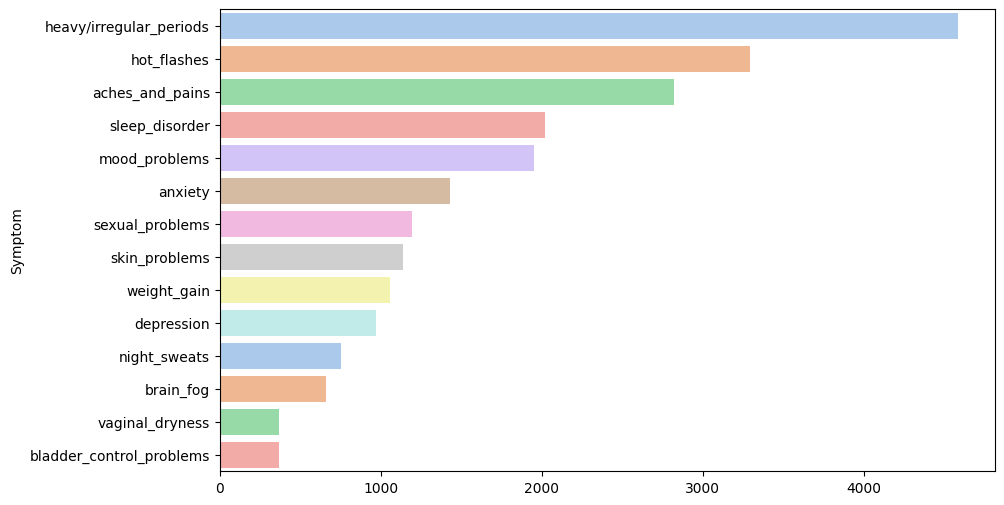

In [86]:
# Frequency of symptoms
symptoms = df.loc[:,'hot_flashes':"weight_gain"]
true_counts = symptoms[symptoms].sum()
true_counts_sorted = true_counts.sort_values(ascending=False)
print(true_counts_sorted)

plt.figure(figsize=(10, 6))
sns.barplot(y=true_counts_sorted.index, x=true_counts_sorted.values, palette='pastel')
plt.ylabel("Symptom")

/var/folders/dn/rl_q0_c94855cyqxym38ldpw0000gn/T/ipykernel_10019/2657413375.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=medication_counts.index, x=medication_counts.values, palette='pastel')


Text(0, 0.5, 'medication')

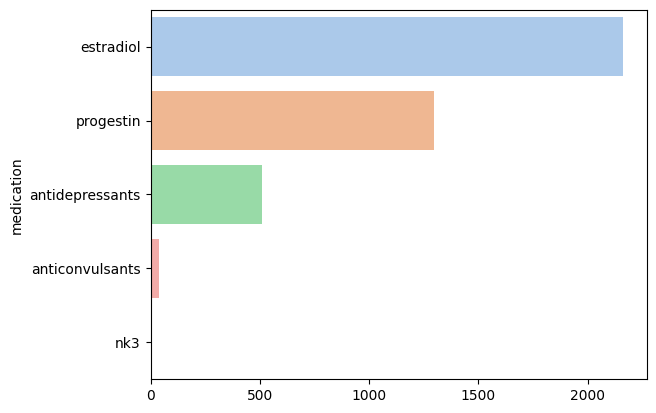

In [87]:
medications = df.loc[:,"antidepressants":"nk3"]
medication_counts = medications[medications].sum().sort_values(ascending=False)

sns.barplot(y=medication_counts.index, x=medication_counts.values, palette='pastel')
plt.ylabel("medication")

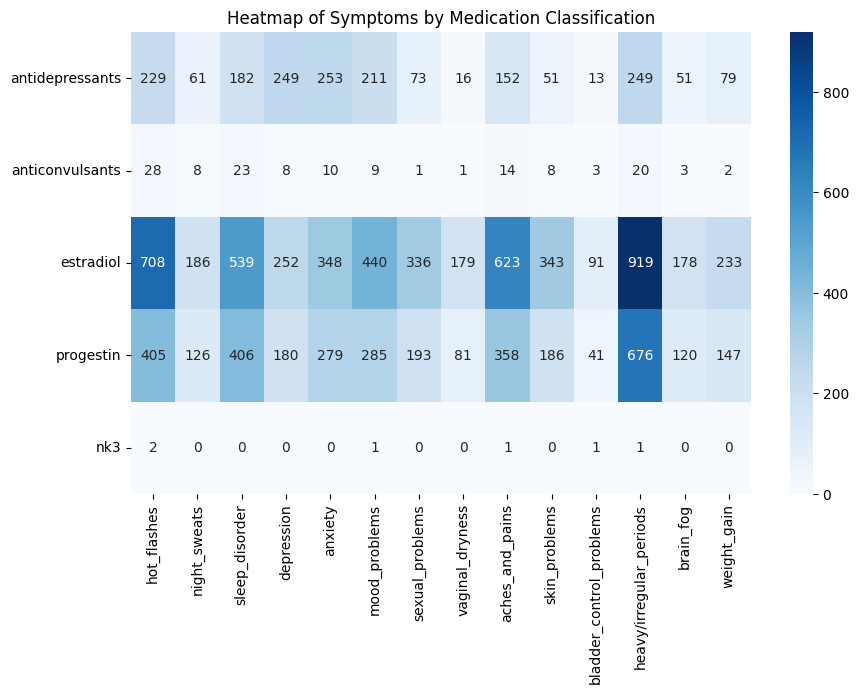

In [96]:
med_columns = ['antidepressants',
       'anticonvulsants', 'estradiol', 'progestin', 'nk3']

# List of symptom columns
symptom_columns = ['hot_flashes', 'night_sweats',
       'sleep_disorder', 'depression', 'anxiety', 'mood_problems',
       'sexual_problems', 'vaginal_dryness', 'aches_and_pains',
       'skin_problems', 'bladder_control_problems', 'heavy/irregular_periods',
       'brain_fog', 'weight_gain']

# Create an empty DataFrame for heatmap data
heatmap_data = pd.DataFrame(0, index=med_columns, columns=symptom_columns)

for med_col in med_columns:
    for symptom_col in symptom_columns:
        heatmap_data.at[med_col,
                        symptom_col] = df[df[med_col] == True][symptom_col].sum()

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='g')
plt.title('Heatmap of Symptoms by Medication Classification')
plt.show()

In [69]:
print(df[df["id"] == "9w0ndk"])
print(len(df[(df["bladder_control_problems"] == True)]))

df.to_csv("processed_reddit.csv")


         id      author created_utc  \
719  9w0ndk  hangrycats  2018-11-10   

                                             title  \
719  Gabapentin vs HRT vs oral birth control pills   

                                              selftext  score  upvote_ratio  \
719  Hi, all.  I'm 48 and have been perimenopausal ...      2           NaN   

     num_comments                                                url   age  \
719             8  https://www.reddit.com/r/Menopause/comments/9w...  48.0   

     ...  brain_fog  weight_gain  hormone_therapy  antidepressants  \
719  ...      False        False             True            False   

     anticonvulsants  estradiol  progestin    nk3  vitamins  exercise  
719             True       True      False  False     False     False  

[1 rows x 35 columns]
366


In [93]:
len(df[(df["antidepressants"]) & (df["hot_flashes"])])

229